In [1]:
import pandas as pd
import tensorflow as tf
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings
from freeman.evaluation import regression_evaluation, f_importances, plot_actual_pred
from freeman.aiddd.data_manager import read_data

# 한글처리 지원
plt_settings()

2023-09-23 21:37:33.966151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_X = read_data('fb-scaling-X')
df_y = read_data('fb-scaling-y')

training_columns = df_X.columns

In [3]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.1)

In [4]:
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1:])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_mlp.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11520     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21889 (85.50 KB)
Trainable params: 21889 (85.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-09-23 21:38:41.797712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 21:38:41.834025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 21:38:41.834486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
history = model_mlp.fit(
    X_train, y_train, 
    epochs=50, verbose=2, validation_split=0.2
)

Epoch 1/50
299/299 - 1s - loss: 3603673382912.0000 - mae: 940699.8750 - val_loss: 3920074899456.0000 - val_mae: 978993.7500 - 616ms/epoch - 2ms/step
Epoch 2/50
299/299 - 1s - loss: 3603711131648.0000 - mae: 938906.0625 - val_loss: 3915519623168.0000 - val_mae: 977250.0625 - 585ms/epoch - 2ms/step
Epoch 3/50
299/299 - 1s - loss: 3603230359552.0000 - mae: 940010.2500 - val_loss: 3940547035136.0000 - val_mae: 992382.0625 - 583ms/epoch - 2ms/step
Epoch 4/50
299/299 - 1s - loss: 3605238906880.0000 - mae: 938774.3750 - val_loss: 3932572352512.0000 - val_mae: 989019.7500 - 640ms/epoch - 2ms/step
Epoch 5/50
299/299 - 1s - loss: 3601452236800.0000 - mae: 941851.6875 - val_loss: 3929795723264.0000 - val_mae: 971858.7500 - 580ms/epoch - 2ms/step
Epoch 6/50
299/299 - 1s - loss: 3604503855104.0000 - mae: 942951.5625 - val_loss: 3936843726848.0000 - val_mae: 981677.4375 - 616ms/epoch - 2ms/step
Epoch 7/50
299/299 - 1s - loss: 3601234395136.0000 - mae: 938332.0000 - val_loss: 3936834027520.0000 - val

In [19]:
model_mlp.evaluate(X_test, y_test, verbose=0)

[4368480075776.0, 1023860.25]

In [20]:
pred_mlp = model_mlp.predict(X_test, verbose=0)
_ = regression_evaluation(y_test, pred_mlp)

R2_SCORE: 0.639007, MAPE: 21.373959, MSE: 4368480348319.840332, RMSE: 2090090.990440, MAE: 1023860.032687


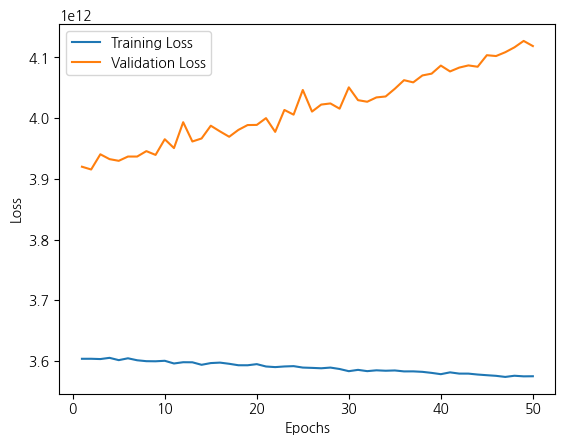

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# loss와 val_loss 값을 그래프로 그립니다.
epochs_range = range(1, len(loss) + 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()